In [30]:
"""
Hello y'all see this?
"""
from google.colab import drive
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.preprocessing import LabelEncoder

In [21]:
# Connect Colab to Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Unzip training data, run once
#!unzip drive/MyDrive/data/train.zip -d drive/MyDrive/data/

In [ ]:
# Unzip validation data, run once
#!unzip drive/MyDrive/data/validation.zip -d drive/MyDrive/data/

In [22]:
# This code chunk puts absolute paths of all training/validation images and
# their labels in seperate dataframes
train_paths = []
train_labels = []
validation_paths = []
validation_labels = []
troot = 'drive/MyDrive/data/train-cropped'
vroot = 'drive/MyDrive/data/validation-cropped'

for f in os.listdir(troot):
  tpath = os.path.join(troot, f)
  tlabel = f[-10:-8]
  train_paths.append(tpath)
  train_labels.append(tlabel)

for f in os.listdir(vroot):
  vpath = os.path.join(vroot, f)
  vlabel = f[-10:-8]
  validation_paths.append(vpath)
  validation_labels.append(vlabel)

train_images = pd.DataFrame({'path': train_paths,
                             'label': train_labels})
validation_images = pd.DataFrame({'path': validation_paths,
                                  'label': validation_labels})

In [23]:
def get_subset(n, data, seed=123):
  """
  input: number of samples, dataframe to be sampled from

  output: subset of rows from dataframe
  """
  random.seed(seed)
  sub = random.sample(range(data.shape[0] + 1), n)
  return data.iloc[sub,:]

In [24]:
imageWidth, imageHeight = 128, 128
channel = 1
imageSize = (imageWidth, imageHeight)
nCategories = 5

# Create model
model = Sequential()

model.add(Conv2D(filters = 64,
                 kernel_size=2,
                 activation='relu',
                 input_shape=(imageWidth, imageHeight, channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(16,
                 kernel_size = 2,
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

#model.add(Conv2D(filters = 128,
#                 kernel_size=2,
#                 activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(nCategories, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 127, 127, 64)      320       
                                                                 
 batch_normalization_6 (Bat  (None, 127, 127, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 63, 63, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 16)        4112      
                                                                 
 batch_normalization_7 (Bat  (None, 62, 62, 16)       

In [25]:
# Prepare training data generator

train_subset = get_subset(1000, train_images)

train_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe = train_subset,
    directory = None,         # `train_subset` contains absolute paths
    x_col='path',
    y_col='label',
    class_mode='categorical',  # target is 2-D array of one-hot encoded labels
    target_size=imageSize,
    color_mode="grayscale",
    shuffle=False
    )
label_map = train_generator.class_indices

Found 1000 validated image filenames belonging to 5 classes.


In [26]:
## Model Training:
history = model.fit(
    train_generator,
    epochs = 1
)

32/32 [==============================] - 22s 644ms/step - loss: 0.8914 - accuracy: 0.7050


In [27]:
# Prepare validation data generator

validation_subset = get_subset(1000, validation_images)

validation_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_dataframe(
    dataframe = validation_subset,
    directory = None,
    x_col='path',
    class_mode= None,
    target_size=imageSize,
    color_mode="grayscale",
    shuffle=False
    )

Found 1000 validated image filenames.


In [28]:
## Make categorical prediction:
print(" --- Predicting on validation data ---")
phat = model.predict(validation_generator)
print("Predicted probability array shape:", phat.shape)
print("Example:\n", phat[:5])

 --- Predicting on validation data ---
32/32 [==============================] - 251s 8s/step
Predicted probability array shape: (1000, 5)
Example:
 [[0.38520503 0.20886876 0.14016508 0.15818706 0.10757409]
 [0.37212098 0.18713275 0.11927367 0.20872094 0.11275155]
 [0.37028092 0.20321052 0.14333689 0.17451596 0.10865569]
 [0.39453527 0.19468488 0.12167319 0.16681138 0.12229519]
 [0.37117    0.17356506 0.11106545 0.23277578 0.11142364]]


In [29]:
## Convert labels to categories:
validation_subset['predicted'] = pd.Series(np.argmax(phat, axis=1),
                                           index=validation_subset.index)
print(validation_subset.head())
labelMap = {v: k for k, v in label_map.items()}
validation_subset["predicted"] = validation_subset.predicted.replace(labelMap)
print("confusion matrix (validation)")
print(pd.crosstab(validation_subset.label, validation_subset.predicted))
print("Validation accuracy", np.mean(validation_subset.label == validation_subset.predicted))

                                                   path label  predicted
428   drive/MyDrive/data/validation-cropped/tolstoy-...    RU          0
2192  drive/MyDrive/data/validation-cropped/novel_00...    TH          0
714   drive/MyDrive/data/validation-cropped/tolstoy-...    RU          0
6299  drive/MyDrive/data/validation-cropped/chinese-...    ZN          0
3336  drive/MyDrive/data/validation-cropped/novel_00...    TH          0
confusion matrix (validation)
predicted   DA
label         
DA         147
EN         259
RU         214
TH         230
ZN         150
Validation accuracy 0.147


<ipython-input-29-8fb2affa4847>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset['predicted'] = pd.Series(np.argmax(phat, axis=1),
<ipython-input-29-8fb2affa4847>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_subset["predicted"] = validation_subset.predicted.replace(labelMap)


Example wrong results (validation data)
                                                   path label predicted
3645  drive/MyDrive/data/validation-cropped/novel_00...    TH        DA
6884  drive/MyDrive/data/validation-cropped/claudes-...    EN        DA
3719  drive/MyDrive/data/validation-cropped/novel_00...    TH        DA
6472  drive/MyDrive/data/validation-cropped/chinese-...    ZN        DA
4382  drive/MyDrive/data/validation-cropped/evolutio...    EN        DA
4453  drive/MyDrive/data/validation-cropped/journey_...    EN        DA
760   drive/MyDrive/data/validation-cropped/tolstoy-...    RU        DA
2794  drive/MyDrive/data/validation-cropped/novel_00...    TH        DA
5824  drive/MyDrive/data/validation-cropped/evolutio...    EN        DA
102   drive/MyDrive/data/validation-cropped/tolstoy-...    RU        DA


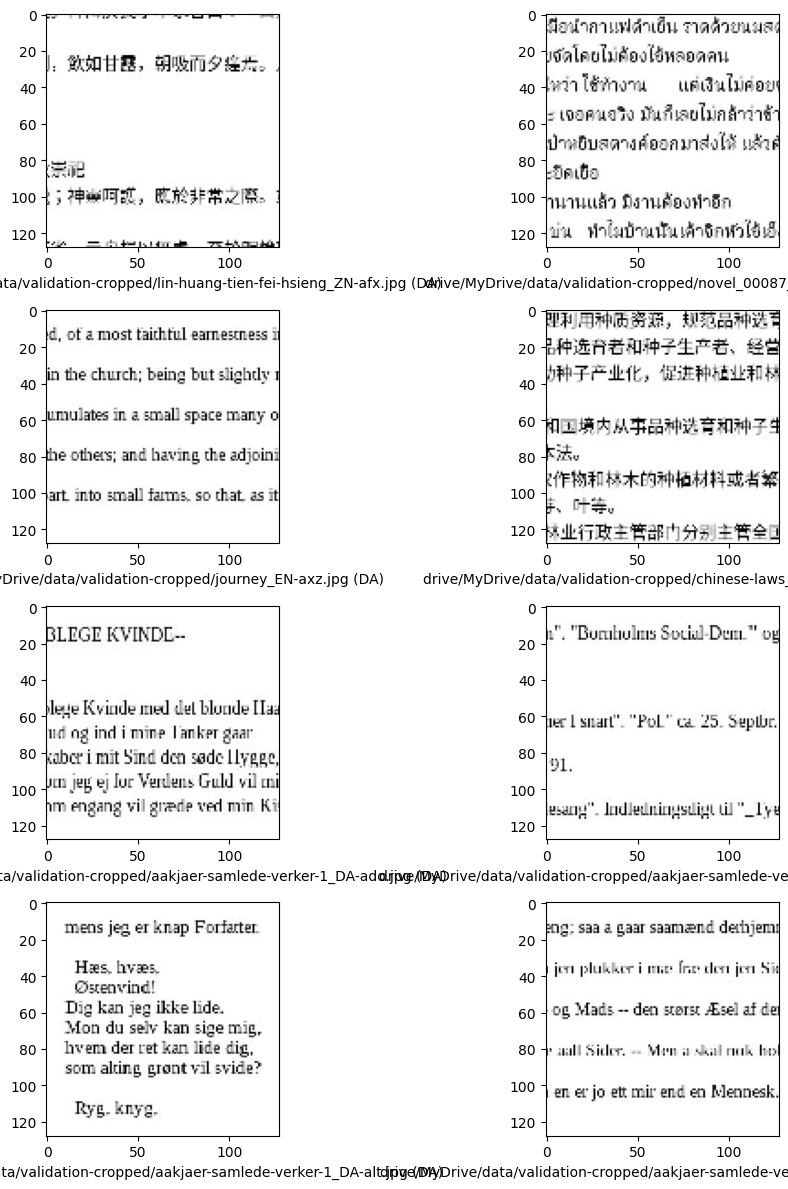

In [34]:
## Print and plot misclassified results
wrongResults = validation_subset[validation_subset.predicted != validation_subset.label]
rows = np.random.choice(wrongResults.index, min(4, wrongResults.shape[0]), replace=False)
print("Example wrong results (validation data)")
print(wrongResults.sample(min(10, wrongResults.shape[0])))

## Plot 4 wrong and 4 correct results
plt.figure(figsize=(12, 12))
index = 1
for row in rows:
    filename = wrongResults.loc[row, 'path']
    predicted = wrongResults.loc[row, 'predicted']
    img = load_img(filename, target_size=imageSize)
    plt.subplot(4, 2, index)
    plt.imshow(img)
    plt.xlabel(filename + " ({})".format(predicted))
    index += 1
# now show correct results
index = 5
correctResults = validation_subset[validation_subset.predicted == validation_subset.label]
rows = np.random.choice(correctResults.index,
                        min(4, correctResults.shape[0]), replace=False)
for row in rows:
    filename = correctResults.loc[row, 'path']
    predicted = correctResults.loc[row, 'predicted']
    img = load_img(filename, target_size=imageSize)
    plt.subplot(4, 2, index)
    plt.imshow(img)
    plt.xlabel(filename + " ({})".format(predicted))
    index += 1
plt.tight_layout()
plt.show()